## Minnesota State COVID Response Analysis
This notebook contains the work to identify associations between the Minnesota state governmental response and the COVID-19 case count throughout the pandemic.


## Data Cleanup
As with most data mining projects, we will need to clean up the given data file in order to focus on the goal at hand. The "all-states-history.csv" file is a dataset of U.S. COVID-19 cases and deaths dating from the start of the pandemic to 11/29/20 and was sourced from [The Covid Tracking Project](https://covidtracking.com/data). We are analyzing 3 periods throughout this timeline:

- Early Breakout (Early March -> May)
- Summer (June -> August)
- Fall/Present (September -> Late November)

We will divide up the data into 3 different frames according to these periods.

In order to analyze with state policy actions, we will merge data from the [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker) github dataset titled 'state-policies.csv'. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import squarify
import seaborn as sns
from datetime import datetime as dt

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

Need to a way to discretize and format data too be suitable for apriori analysis. The function below will discretize the necessary columns into bins and set the values to strings according to the bin they are placed in.  

In [2]:
def discretize_data(arr, k):
    cols = arr.columns
    for i in cols:
        bin_range = pd.cut(arr[i],k)
        col_copy = arr[i].astype('str')
        for j in range(len(col_copy)):
            col_copy[j] = i + "" +str(bin_range[j])
            
        arr[i] = col_copy   

Initializing the dataframes

In [3]:
# COVID tracking project data
covid_data = pd.read_csv('all-states-history.csv')

# state plicy data
policy_data = pd.read_csv('state-policies.csv')

C:\Users\Sam\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Cleaning up Covid data to only include Minnesota instances and the appropriate attributes

In [59]:
#isolating the columns we need
columns_to_show = ['date','deathIncrease','hospitalizedIncrease','negativeIncrease','positiveIncrease','totalTestResultsIncrease']

#isolating only for MN data and putting in order March->November
covid_clean_data = covid_data[covid_data['state'] == 'MN']
covid_clean_data = covid_clean_data[columns_to_show]
covid_clean_data = covid_clean_data.iloc[::-1]
covid_clean_data = covid_clean_data.reset_index(drop = True).fillna(0)

Now we can divide up the covid data into the 3 distinct periods (as well as keep a datframe for the overall period)

In [60]:
# getting start and end dates for dividing up into periods

EB_start = dt.strptime(covid_clean_data['date'][0],"%Y-%m-%d")
EB_end = dt.strptime("2020-05-31", "%Y-%m-%d")

S_start = dt.strptime("2020-06-01", "%Y-%m-%d")
S_end = dt.strptime("2020-08-31", "%Y-%m-%d") 

FP_start = dt.strptime("2020-09-01", "%Y-%m-%d")
FP_end = dt.strptime(covid_clean_data['date'][len(covid_clean_data)-1], "%Y-%m-%d")

#reindexing for weekly processing 
covid_clean_data['date'] = covid_clean_data['date'].astype('datetime64[ns]')
covid_clean_data = covid_clean_data.set_index('date')

#dividing up into different time periods
full_period = covid_clean_data

early_breakout = covid_clean_data[EB_start:EB_end].reset_index(drop=True)

summer = covid_clean_data[S_start:S_end].reset_index(drop=True)

fall = covid_clean_data[FP_start:FP_end].reset_index(drop=True)

In [61]:
EB = early_breakout.copy()
SUMMER = summer.copy()
FALL = fall.copy()

In [260]:
full_period.describe()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
count,269.000000,269.000000,269.000000,269.000000,269.000000
mean,13.301115,61.869888,8200.933086,1163.449814,15303.732342
std,14.222199,66.883962,12928.643507,1775.559248,15136.648298
min,-24.000000,0.000000,-174299.000000,0.000000,0.000000
25%,4.000000,29.000000,3699.000000,312.000000,4913.000000
50%,9.000000,41.000000,8537.000000,618.000000,12292.000000
75%,18.000000,64.000000,12826.000000,941.000000,18724.000000
max,101.000000,380.000000,39310.000000,9022.000000,105119.000000


After dividing up the data into the periods, we can discretize into the k bins using the "discretize_data" function implemented earlier.

In [62]:
discretize_data(full_period,10)
discretize_data(early_breakout,6)
discretize_data(summer,6)
discretize_data(fall,6)


In [ ]:
# converting remaining non-sum columns to weekly index
remaining_cols = covid_clean_data[['state','death','deathConfirmed','hospitalized', 'negative','positive','totalTestResults']]
#remaining_cols = remaining_cols.resample('W').backfill().reset_index()
#remaining_cols.head(39)

#merging and resetting the datframe order to be more clear
#covid_clean_data = pd.merge(remaining_cols, weekly_data, left_index = True, right_index = True).fillna(0)
#covid_clean_data = covid_clean_data[['date','state','death','deathIncrease','deathConfirmed','hospitalized', 'hospitalizedIncrease','negative',
                        #'negativeIncrease','positive', 'positiveIncrease','totalTestResults','totalTestResultsIncrease']]


Cleaning up state policy dataframe:

In [7]:
#isolating data only about the current state of interest, Minnesota
policy_clean_data = policy_data[policy_data['RegionName'] == 'Minnesota']
#deleting rows whose dates are outside of the scope of this project
policy_clean_data = policy_clean_data.iloc[60:] #delete the first 60 rows due to their January - February dates
policy_clean_data = policy_clean_data.iloc[:-3,] #as well as the last 3 rows due to their December dates

#declaring and extracting columns of interest from the original dataset
columns_of_interest = ['Date', 'C1_School closing', 'C2_Workplace closing', 
                       'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C6_Stay at home requirements', 
                       'C7_Restrictions on internal movement', 'C8_International travel controls', 
                       'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 
                       'H4_Emergency investment in healthcare', 
                       'H6_Facial Coverings']
policy_clean_data = policy_clean_data[columns_of_interest].fillna(0)

# reformating date section and range of dates needed
policy_clean_data = policy_clean_data.reset_index(drop = True)

date_col = policy_clean_data['Date'].astype('str')
for i in range(policy_clean_data.shape[0]):
    date_col[i] = dt.strptime(date_col[i], "%Y%m%d")
    
policy_clean_data['Date'] = date_col

start_date = dt.strptime('20200306', "%Y%m%d")
end_date = dt.strptime('20201129', "%Y%m%d")

policy_clean_data = policy_clean_data.rename(columns = {"Date": "date"})

policy_clean_data = policy_clean_data.set_index('date')


Changing values of policy_clean_data to the type of policy each number corresponds to:

In [8]:
#C1_School closing
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(0, 'no measures, school closing')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(1, 'recommend closing or all schools open with alterations')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(2, 'require closing only some levels or categories')
policy_clean_data['C1_School closing'] = policy_clean_data['C1_School closing'].replace(3, 'require closing all levels, school closing')
#C2_Workplace closing
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(0, 'no measures, workplace closing')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(1, 'recommend closing (or recommend work from home)')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(2, 'require closing (or work from home) for some sectors or categories of workers')
policy_clean_data['C2_Workplace closing'] = policy_clean_data['C2_Workplace closing'].replace(3, 'require closing (or work from home) for all-but-essential workplaces (eg grocery stores, doctors)')
#C3_Cancel public events
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(0, 'no measures, cancel public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(1, 'recommend cancelling public events')
policy_clean_data['C3_Cancel public events'] = policy_clean_data['C3_Cancel public events'].replace(2, 'require cancelling public events')
#C4_Restrictions on gatherings                                                                                            
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(0, 'no restrictions on gatherings')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(1, 'restrictions on very large gatherings (the limit is above 1000 people)')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(2, 'restrictions on gatherings between 101-1000 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(3, 'restrictions on gatherings between 11-100 people')                                                                                              
policy_clean_data['C4_Restrictions on gatherings'] = policy_clean_data['C4_Restrictions on gatherings'].replace(4, 'restrictions on gatherings of 10 people or less')
#C6_Stay at home requirements                                                                                            
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(0, 'no measures for stay at home requirement')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(1, 'recommend not leaving house')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(2, 'require not leaving house with exceptions for "essential" activities')
policy_clean_data['C6_Stay at home requirements'] = policy_clean_data['C6_Stay at home requirements'].replace(3, 'require not leaving house with minimal exceptions')
#C7_Restrictions on internal movement
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(0, 'no measures on restrictions on internal movement')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(1, 'recommend not to travel between regions/cities')
policy_clean_data['C7_Restrictions on internal movement'] = policy_clean_data['C7_Restrictions on internal movement'].replace(2, 'internal movement restrictions in place')
#C8_International travel controls
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(0, 'no restrictions on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(1, 'screening arrivals on international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(2, 'quarantine arrivals from some or all regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(3, 'ban arrivals from some regions for international travel')
policy_clean_data['C8_International travel controls'] = policy_clean_data['C8_International travel controls'].replace(4, 'ban on all regions or total border closure')
#H1_Public information campaigns
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(0, 'no Covid-19 public information campaign')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(1, 'public officials urging caution about Covid-19')
policy_clean_data['H1_Public information campaigns'] = policy_clean_data['H1_Public information campaigns'].replace(2, 'coordinated public information campaign ')
#H2_Testing policy
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(0, 'no testing policy')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(1, 'only those who both (a) have symptoms AND (b) meet specific criteria')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(2, 'testing of anyone showing Covid-19 symptoms')
policy_clean_data['H2_Testing policy'] = policy_clean_data['H2_Testing policy'].replace(3, 'open public testing')
#H3_Contact tracing
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(0, 'no contact tracing')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(1, 'limited contact tracing; not done for all cases')
policy_clean_data['H3_Contact tracing'] = policy_clean_data['H3_Contact tracing'].replace(2, 'comprehensive contact tracing; done for all identified cases')
#H4_Emergency investment in healthcare
### not a code, simply records the monetary value in USD
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].mask(policy_clean_data['H4_Emergency investment in healthcare'] > 0, 'investment')
policy_clean_data['H4_Emergency investment in healthcare'] = policy_clean_data['H4_Emergency investment in healthcare'].replace(0, 'no new spending that day')

#H6_Facial Coverings
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(0, 'no policy on facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(1, 'recommended facial coverings')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(2, 'facial coverings required in some specified shared/public spaces')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(3, 'facial coverings required in all shared/public spaces')
policy_clean_data['H6_Facial Coverings'] = policy_clean_data['H6_Facial Coverings'].replace(4, 'facial coverings required outside the home at all times')
   

We decided to drop some columns that skewed the Apriori results and didn't offer much info in general:

In [9]:
policy_clean_data = policy_clean_data.drop(['H1_Public information campaigns','H4_Emergency investment in healthcare','H3_Contact tracing'], axis = 1)

Dividing up the policy data into the seperate periods:

In [10]:
early_breakout_policy = policy_clean_data[EB_start:EB_end].reset_index(drop=True)

summer_policy = policy_clean_data[S_start:S_end].reset_index(drop=True)

fall_policy = policy_clean_data[FP_start:FP_end].reset_index(drop=True)

In [15]:
MN_freq_itemsets_C1 = apriori(MN_te_basket_C1, min_support=0.15, use_colnames=True)
MN_freq_itemsets_C1['length'] = MN_freq_itemsets_C1['itemsets'].apply(lambda x: len(x))
rules_C1 = association_rules(MN_freq_itemsets_C1, metric="confidence", min_threshold=0.3)
rules_C1["antecedent_len"] = rules_C1["antecedents"].apply(lambda x: len(x))

In [16]:
rules_C1[rules_C1["conviction"] >= 10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1,"(hospitalizedIncrease(-0.102, 17.0])","(deathIncrease(-0.035, 5.833])",0.321839,0.402299,0.310345,0.964286,2.396939,0.180869,16.735632,1
5,"(deathIncrease(-0.035, 5.833])","(positiveIncrease(-0.973, 162.167])",0.402299,0.505747,0.402299,1.000000,1.977273,0.198837,inf,1
13,"(hospitalizedIncrease(-0.102, 17.0])","(positiveIncrease(-0.973, 162.167])",0.321839,0.505747,0.321839,1.000000,1.977273,0.159070,inf,1
19,"(hospitalizedIncrease(17.0, 34.0])",(require closing (or work from home) for all-b...,0.218391,0.436782,0.206897,0.947368,2.168975,0.111507,10.701149,1
24,"(totalTestResultsIncrease(-10.383, 1730.5])","(negativeIncrease(-9.929, 1654.833])",0.471264,0.494253,0.471264,1.000000,2.023256,0.238341,inf,1
25,"(negativeIncrease(-9.929, 1654.833])","(totalTestResultsIncrease(-10.383, 1730.5])",0.494253,0.471264,0.471264,0.953488,2.023256,0.238341,11.367816,1
34,"(hospitalizedIncrease(-0.102, 17.0], negativeI...","(deathIncrease(-0.035, 5.833])",0.287356,0.402299,0.275862,0.960000,2.386286,0.160259,14.942529,2
39,"(positiveIncrease(-0.973, 162.167], hospitaliz...","(deathIncrease(-0.035, 5.833])",0.321839,0.402299,0.310345,0.964286,2.396939,0.180869,16.735632,2
40,"(deathIncrease(-0.035, 5.833], hospitalizedInc...","(positiveIncrease(-0.973, 162.167])",0.310345,0.505747,0.310345,1.000000,1.977273,0.153389,inf,2
43,"(hospitalizedIncrease(-0.102, 17.0])","(positiveIncrease(-0.973, 162.167], deathIncre...",0.321839,0.402299,0.310345,0.964286,2.396939,0.180869,16.735632,1


Merging case and policy dataframes to create the basket:

In [17]:
MN_basket_full = pd.merge(full_period, policy_clean_data,left_index = True, right_index = True)

MN_basket_EB = pd.merge(early_breakout, early_breakout_policy,left_index = True, right_index = True)

MN_basket_summer = pd.merge(summer, summer_policy,left_index = True, right_index = True)

MN_basket_fall = pd.merge(fall, fall_policy,left_index = True, right_index = True)

## Analysis

Important MN Stats:

- Population (mn.gov estimate): 5,680,337
- Land Area (estimate): 79,610.08 sq. mi.
- Population Density: 71.35 people/sq. mi.

Below will be a breakdown of each of the time periods (including overall time) to see if any noticeable associations formed between increases and state policy.

## Full Pandemic Period

#### All Policies Included

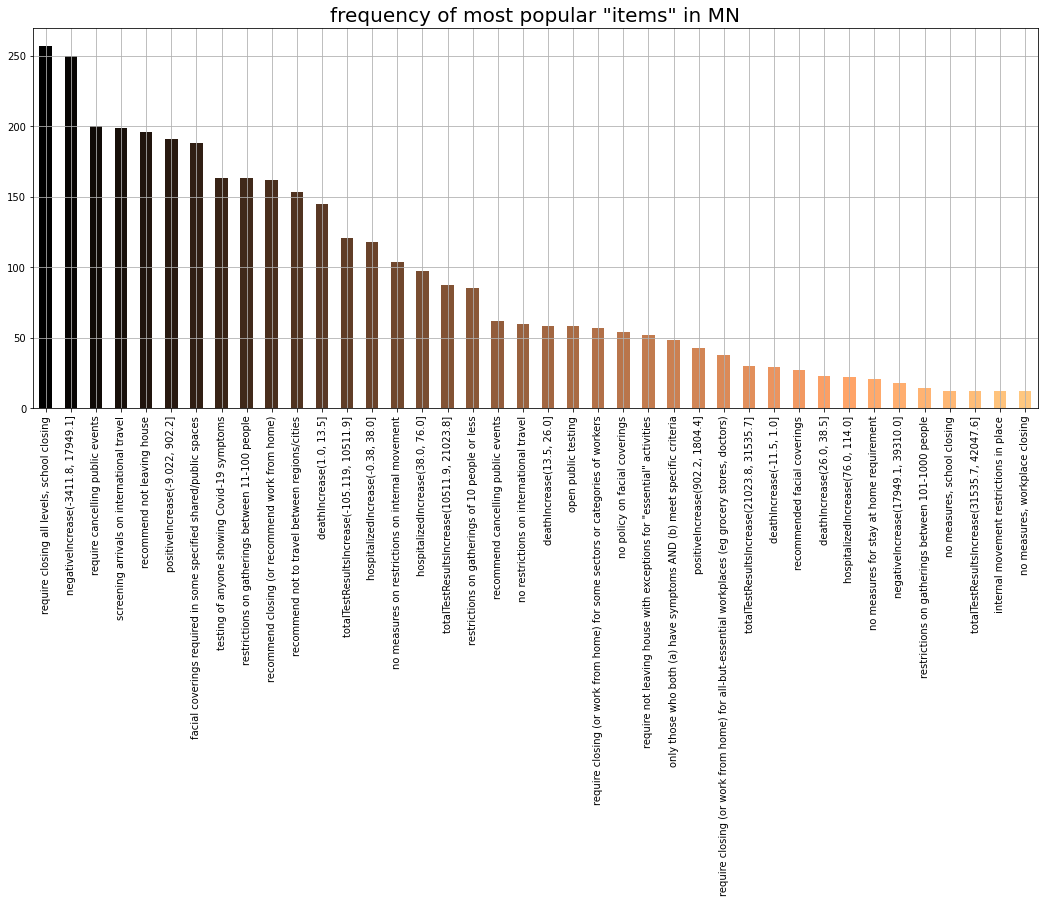

In [18]:
from wordcloud import WordCloud

#full pandemic period

all_elements = MN_basket_full.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular "items" in MN', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

In [19]:
basket_array_full = MN_basket_full.values
basket_cols_full = MN_basket_full.columns
te_full = TransactionEncoder()
te_dataset_full = te_full.fit(basket_array_full).transform(basket_array_full)

MN_te_basket_full = pd.DataFrame(te_dataset_full, columns = te_full.columns_)
MN_te_basket_full = MN_te_basket_full.drop("require closing all levels, school closing", axis = 1) 

In [20]:
# full period

MN_freq_itemsets_full = apriori(MN_te_basket_full, min_support=0.4, use_colnames=True)
MN_freq_itemsets_full['length'] = MN_freq_itemsets_full['itemsets'].apply(lambda x: len(x))
rules_full = association_rules(MN_freq_itemsets_full, metric="conviction", min_threshold=1)
rules_full["antecedent_len"] = rules_full["antecedents"].apply(lambda x: len(x))

In [42]:
trimmed_rules = rules_full[(rules_full['confidence'] <= 0.9) & 
                           (rules_full['conviction'] >= 2) & 
                           (rules_full['support'] >= 0.6)]
trimmed_rules.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
19,(facial coverings required in some specified s...,(recommend closing (or recommend work from home)),0.698885,0.602230,0.602230,0.861702,1.430851,0.181341,2.876180,1
20,(recommend not leaving house),(facial coverings required in some specified s...,0.728625,0.698885,0.646840,0.887755,1.270245,0.137616,2.682663,1
23,(facial coverings required in some specified s...,(restrictions on gatherings between 11-100 peo...,0.698885,0.605948,0.605948,0.867021,1.430851,0.182460,2.963271,1
48,(require cancelling public events),"(positiveIncrease(-9.022, 902.2])",0.743494,0.710037,0.661710,0.890000,1.253455,0.133801,2.636026,1
221,(facial coverings required in some specified s...,(restrictions on gatherings between 11-100 peo...,0.698885,0.602230,0.602230,0.861702,1.430851,0.181341,2.876180,1
302,(require cancelling public events),"(negativeIncrease(-3411.8, 17949.1], positiveI...",0.743494,0.695167,0.646840,0.870000,1.251497,0.129987,2.344867,1
445,(require cancelling public events),"(screening arrivals on international travel, p...",0.743494,0.691450,0.657993,0.885000,1.279919,0.143903,2.683045,1
446,(screening arrivals on international travel),"(require cancelling public events, positiveInc...",0.739777,0.661710,0.657993,0.889447,1.344165,0.168475,3.059986,1
1077,"(negativeIncrease(-3411.8, 17949.1], screening...","(require cancelling public events, positiveInc...",0.724907,0.661710,0.643123,0.887179,1.340738,0.163444,2.998479,2
1083,(require cancelling public events),"(negativeIncrease(-3411.8, 17949.1], screening...",0.743494,0.676580,0.643123,0.865000,1.278489,0.140089,2.395704,1


## Early Breakout/Spring Period

In [77]:
EB.describe()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,12.068966,35.022989,2955.137931,302.540230,3257.678161
std,11.081929,28.933756,2734.925581,296.194382,2942.910395
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,973.500000,57.500000,1060.000000
50%,9.000000,31.000000,1664.000000,156.000000,1831.000000
75%,22.500000,54.000000,4850.500000,586.000000,5301.500000
max,35.000000,102.000000,9929.000000,973.000000,10383.000000


In [69]:
# quick stats for the early period

EBmaxPositive = max(EB["positiveIncrease"])
EBmaxDeath = max(EB["deathIncrease"])
EBmaxHospital = max(EB["hospitalizedIncrease"])

print("Max Sinlge day Death increase: " + str(EBmaxDeath))
print("Max Sinlge day Case increase: " + str(EBmaxPositive))
print("Max Sinlge day hospitalized increase: " + str(EBmaxHospital))

Max Sinlge day Death increase: 35
Max Sinlge day Case increase: 973
Max Sinlge day hospitalized increase: 102


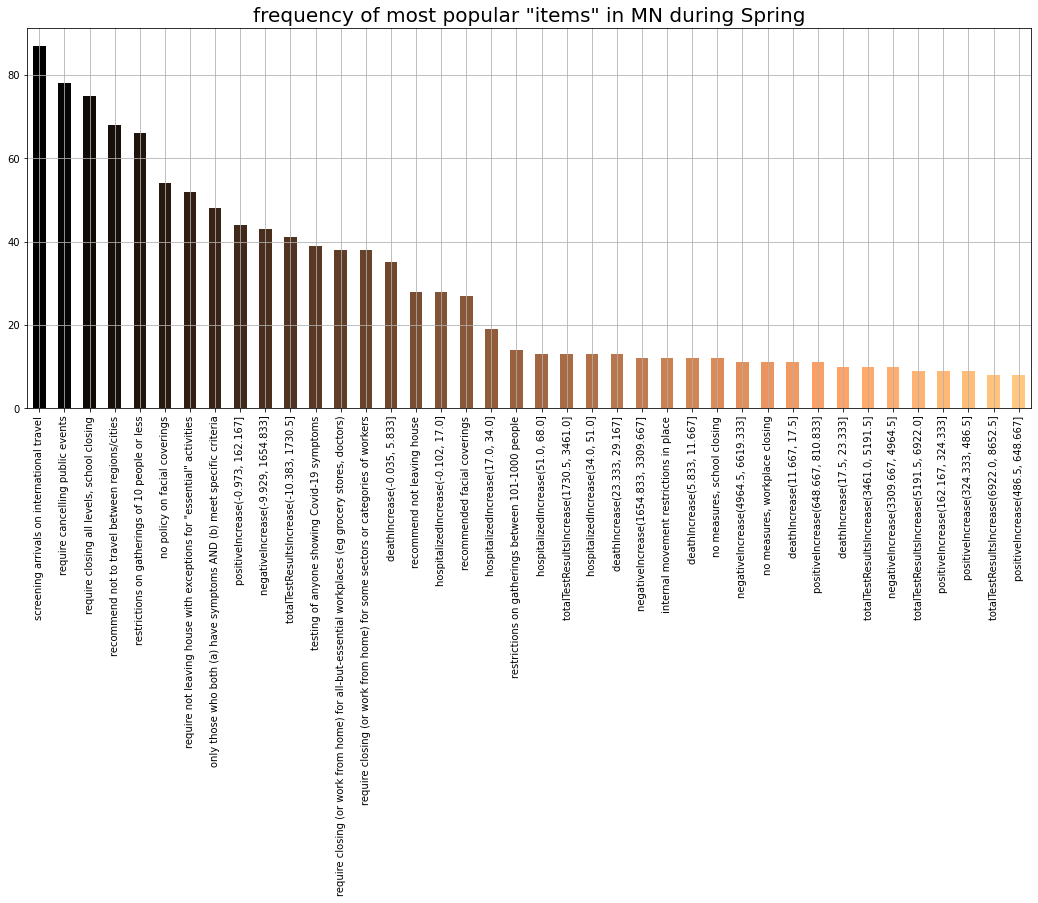

In [31]:
#Early breakout period

all_elements = MN_basket_EB.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular "items" in MN during Spring', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

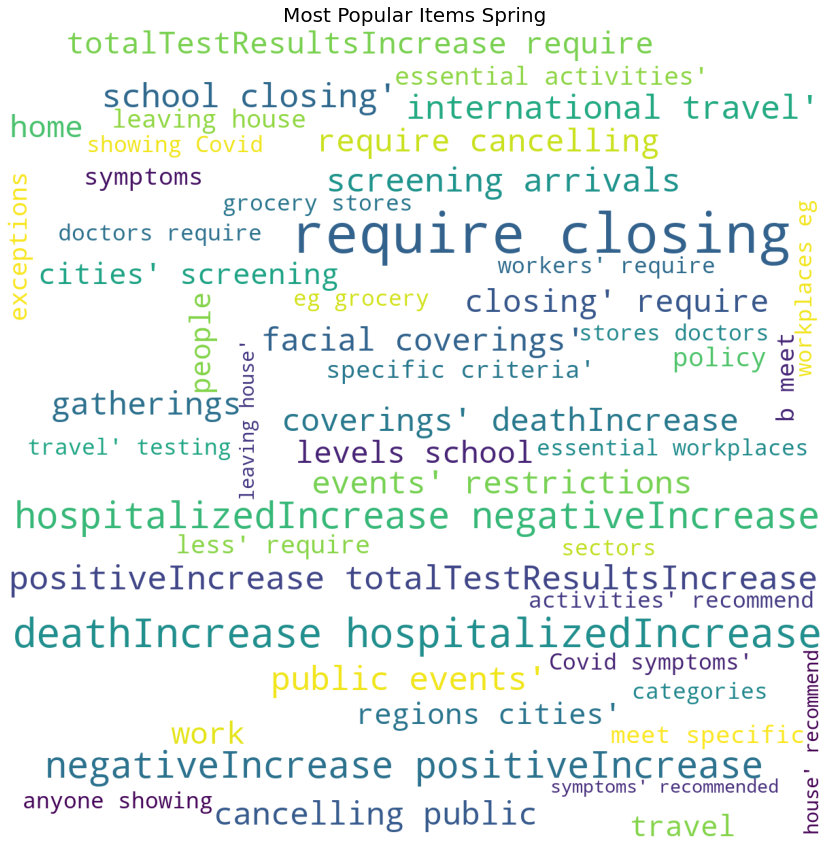

In [32]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 50).generate(str(flat_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Spring',fontsize = 20)
plt.show()

As we can maybe see from the chart above, the "screeing arrivals on international travel" shows up in 100% of the days, so we can leave that out to avoid any skew.

In [44]:
basket_array_EB = MN_basket_EB.values
basket_cols_EB = MN_basket_EB.columns
te_EB = TransactionEncoder()
te_dataset_EB = te_EB.fit(basket_array_EB).transform(basket_array_EB)

MN_te_basket_EB = pd.DataFrame(te_dataset_EB, columns = te_EB.columns_)
MN_te_basket_EB = MN_te_basket_EB.drop("screening arrivals on international travel", axis = 1) 

In [45]:
# EB period

MN_freq_itemsets_EB = apriori(MN_te_basket_EB, min_support=0.4, use_colnames=True)
MN_freq_itemsets_EB['length'] = MN_freq_itemsets_EB['itemsets'].apply(lambda x: len(x))
rules_EB = association_rules(MN_freq_itemsets_EB, metric="conviction", min_threshold=0.3)
rules_EB["antecedent_len"] = rules_EB["antecedents"].apply(lambda x: len(x))

In [56]:
trimmed_rules_EB = rules_EB[(rules_EB['confidence'] <= 0.9) & 
                           (rules_EB['conviction'] >= 1) & 
                           (rules_EB['support'] >= 0.5)]
trimmed_rules_EB.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
14,(no policy on facial coverings),(only those who both (a) have symptoms AND (b)...,0.620690,0.551724,0.551724,0.888889,1.611111,0.209275,4.034483,1
39,(require cancelling public events),(recommend not to travel between regions/cities),0.896552,0.781609,0.758621,0.846154,1.082579,0.057868,1.419540,1
42,"(require closing all levels, school closing)",(recommend not to travel between regions/cities),0.862069,0.781609,0.724138,0.840000,1.074706,0.050337,1.364943,1
46,(restrictions on gatherings of 10 people or less),(recommend not to travel between regions/cities),0.758621,0.781609,0.620690,0.818182,1.046791,0.027745,1.201149,1
47,(recommend not to travel between regions/cities),(restrictions on gatherings of 10 people or less),0.781609,0.758621,0.620690,0.794118,1.046791,0.027745,1.172414,1
56,(require cancelling public events),(require not leaving house with exceptions for...,0.896552,0.597701,0.597701,0.666667,1.115385,0.061831,1.206897,1
59,(require cancelling public events),(restrictions on gatherings of 10 people or less),0.896552,0.758621,0.758621,0.846154,1.115385,0.078478,1.568966,1
70,"(require closing all levels, school closing)",(require not leaving house with exceptions for...,0.862069,0.597701,0.597701,0.693333,1.160000,0.082442,1.311844,1
73,"(require closing all levels, school closing)",(restrictions on gatherings of 10 people or less),0.862069,0.758621,0.758621,0.880000,1.160000,0.104637,2.011494,1
76,(restrictions on gatherings of 10 people or less),(require not leaving house with exceptions for...,0.758621,0.597701,0.597701,0.787879,1.318182,0.144273,1.896552,1


## Summer Period

In [76]:
SUMMER.describe()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
count,92.000000,92.000000,92.000000,92.000000,92.000000
mean,8.869565,37.315217,8641.586957,538.500000,13111.641304
std,6.831114,11.389150,19787.741888,229.558559,5156.990942
min,0.000000,0.000000,-174299.000000,0.000000,0.000000
25%,4.750000,30.000000,8012.750000,407.000000,9643.000000
50%,7.000000,36.500000,10579.000000,522.500000,13078.000000
75%,10.000000,46.250000,13208.750000,714.750000,16315.250000
max,39.000000,69.000000,28331.000000,1154.000000,34867.000000


In [70]:
# quick stats

SUMMERmaxPositive = max(SUMMER["positiveIncrease"])
SUMMERmaxDeath = max(SUMMER["deathIncrease"])
SUMMERmaxHospital = max(SUMMER["hospitalizedIncrease"])

print("Max Sinlge day Death increase: " + str(SUMMERmaxDeath))
print("Max Sinlge day Case increase: " + str(SUMMERmaxPositive))
print("Max Sinlge day hospitalized increase: " + str(SUMMERmaxHospital))

Max Sinlge day Death increase: 39
Max Sinlge day Case increase: 1154
Max Sinlge day hospitalized increase: 69


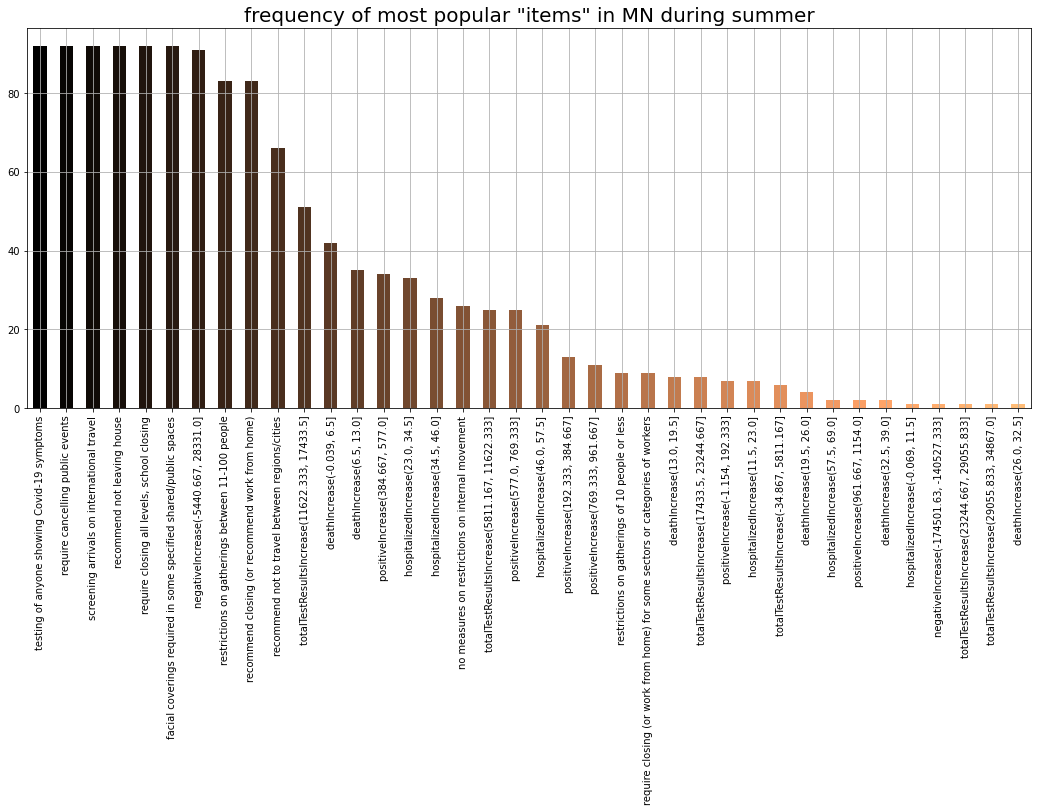

In [29]:
#summer period

all_elements = MN_basket_summer.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular "items" in MN during summer', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

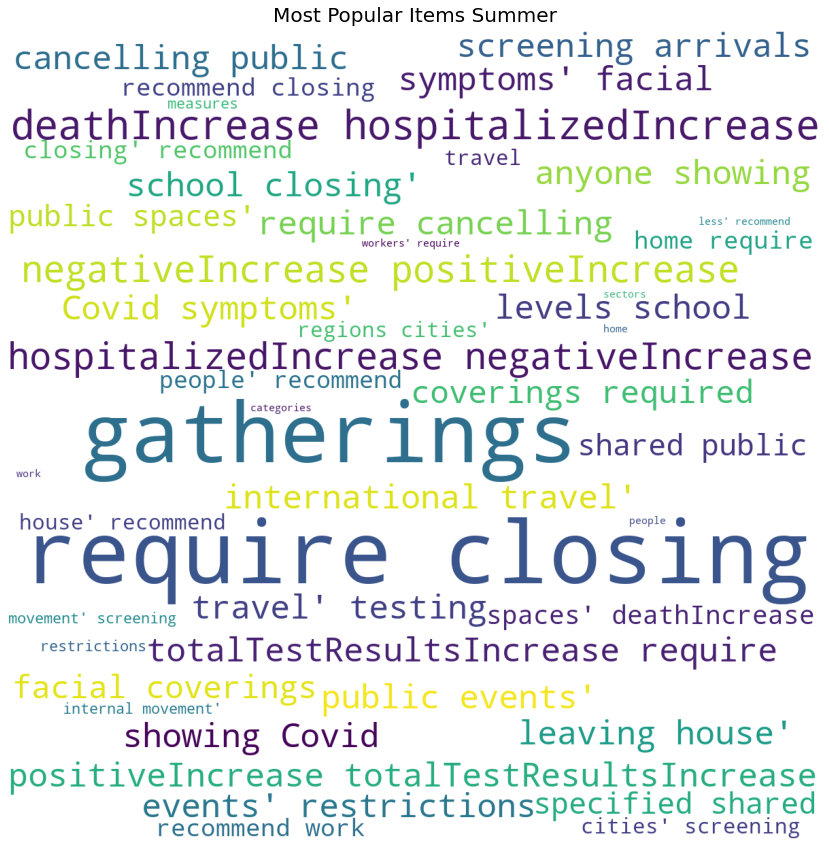

In [30]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 50).generate(str(flat_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Summer',fontsize = 20)
plt.show()

In [35]:
basket_array_summer = MN_basket_summer.values
basket_cols_summer = MN_basket_summer.columns
te_summer = TransactionEncoder()
te_dataset_summer = te_summer.fit(basket_array_summer).transform(basket_array_summer)
MN_te_basket_summer = pd.DataFrame(te_dataset_summer, columns = te_summer.columns_)

In [36]:
# summer period

MN_freq_itemsets_summer = apriori(MN_te_basket_summer, min_support=0.6, use_colnames=True)
MN_freq_itemsets_summer['length'] = MN_freq_itemsets_summer['itemsets'].apply(lambda x: len(x))
rules_summer = association_rules(MN_freq_itemsets_summer, metric="conviction", min_threshold=0.3)
rules_summer["antecedent_len"] = rules_summer["antecedents"].apply(lambda x: len(x))

In [37]:
trimmed_rules_summer = rules_summer[(rules_summer['confidence'] >= 0.7) & 
                                    (rules_summer['support'] >= 0.7) & 
                                    (rules_summer['conviction'] > 1) &
                                    (rules_summer['lift'] > 1)]
trimmed_rules_summer.head(40)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
42,(restrictions on gatherings between 11-100 peo...,(recommend closing (or recommend work from home)),0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,1
43,(recommend closing (or recommend work from home)),(restrictions on gatherings between 11-100 peo...,0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,1
163,(restrictions on gatherings between 11-100 peo...,(recommend closing (or recommend work from home)),0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,2
164,(recommend closing (or recommend work from hom...,(restrictions on gatherings between 11-100 peo...,0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,2
165,(restrictions on gatherings between 11-100 peo...,(recommend closing (or recommend work from hom...,0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,1
166,(recommend closing (or recommend work from home)),(restrictions on gatherings between 11-100 peo...,0.902174,0.902174,0.902174,1.000000,1.108434,0.088256,inf,1
330,(restrictions on gatherings between 11-100 peo...,(recommend closing (or recommend work from home)),0.891304,0.902174,0.891304,1.000000,1.108434,0.087193,inf,2
332,"(negativeIncrease(-5440.667, 28331.0], recomme...",(restrictions on gatherings between 11-100 peo...,0.891304,0.902174,0.891304,1.000000,1.108434,0.087193,inf,2
333,(restrictions on gatherings between 11-100 peo...,"(negativeIncrease(-5440.667, 28331.0], recomme...",0.902174,0.891304,0.891304,0.987952,1.108434,0.087193,9.021739,1
335,(recommend closing (or recommend work from home)),(restrictions on gatherings between 11-100 peo...,0.902174,0.891304,0.891304,0.987952,1.108434,0.087193,9.021739,1


## Fall Period

In [75]:
FALL.describe()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,19.022222,112.922222,12821.422222,2634.500000,29189.055556
std,19.693139,92.550773,6859.785911,2457.246217,17680.085310
min,-24.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,43.000000,8547.500000,912.500000,17196.000000
50%,13.000000,68.500000,11998.500000,1430.500000,26409.500000
75%,24.750000,165.000000,16277.000000,3938.000000,34247.750000
max,101.000000,380.000000,39310.000000,9022.000000,105119.000000


In [71]:
# quick stats

FALLmaxPositive = max(FALL["positiveIncrease"])
FALLmaxDeath = max(FALL["deathIncrease"])
FALLmaxHospital = max(FALL["hospitalizedIncrease"])

print("Max Sinlge day Death increase: " + str(FALLmaxDeath))
print("Max Sinlge day Case increase: " + str(FALLmaxPositive))
print("Max Sinlge day hospitalized increase: " + str(FALLmaxHospital))

Max Sinlge day Death increase: 101
Max Sinlge day Case increase: 9022
Max Sinlge day hospitalized increase: 380


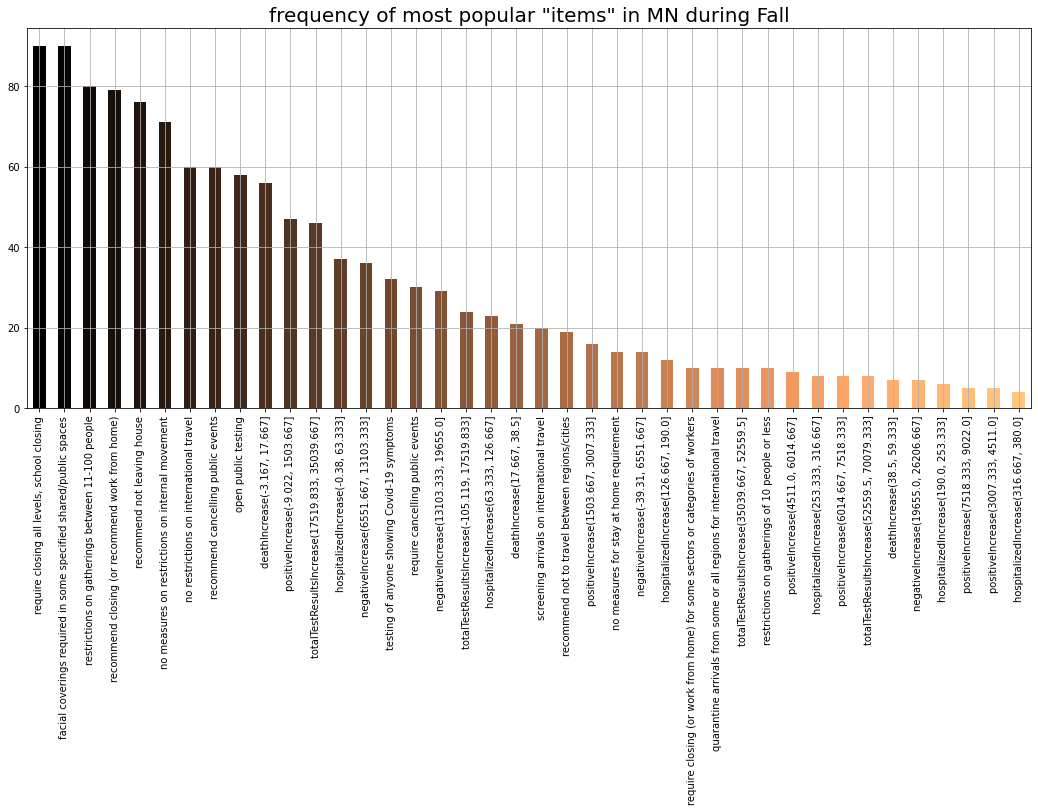

In [33]:
#fall period

all_elements = MN_basket_fall.values.tolist()
flat_list = [item for sublist in all_elements for item in sublist]
temp_df = pd.DataFrame({'col':flat_list})


plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
temp_df['col'].value_counts().head(40).plot.bar(color = color)
plt.title('frequency of most popular "items" in MN during Fall', fontsize = 20)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

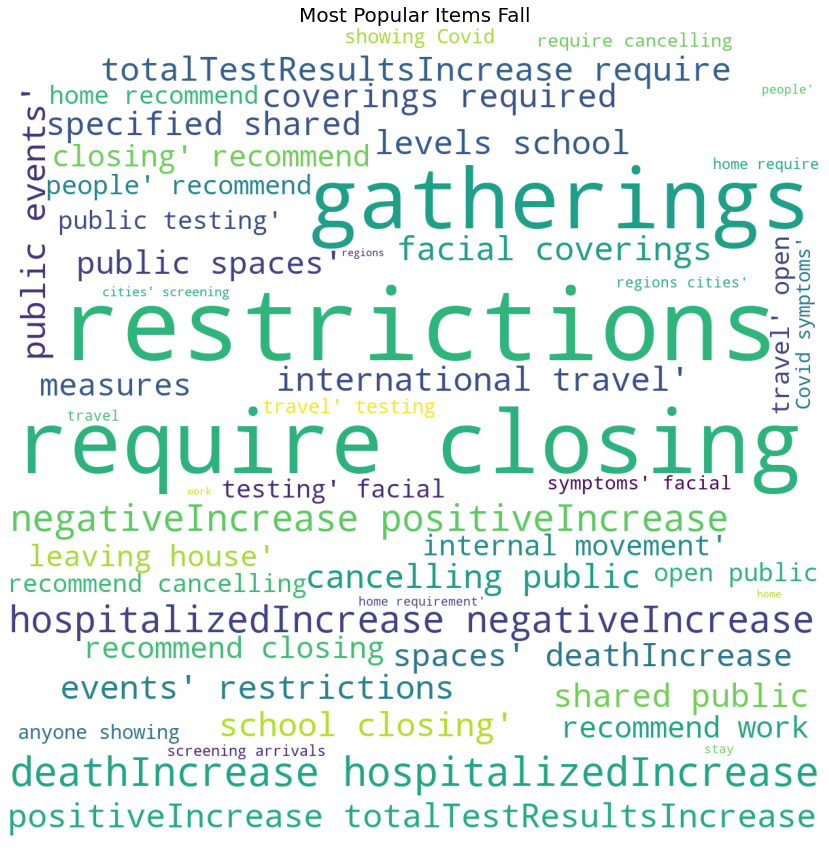

In [34]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 50).generate(str(flat_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Fall',fontsize = 20)
plt.show()

Now that we have the data set up as a series of 'transactions' with items (basket), we just need to encode the items and then use Apriori analysis and find association rules:

In [72]:
basket_array_fall = MN_basket_fall.values
basket_cols_fall = MN_basket_fall.columns
te_fall = TransactionEncoder()
te_dataset_fall = te_fall.fit(basket_array_fall).transform(basket_array_fall)

MN_te_basket_fall = pd.DataFrame(te_dataset_fall, columns = te_fall.columns_)

In [ ]:
MN_te_basket_full.head()

Performing apriori and then creating association rules for all periods:

In [73]:
# fall period

MN_freq_itemsets_fall = apriori(MN_te_basket_fall, min_support=0.4, use_colnames=True)
MN_freq_itemsets_fall['length'] = MN_freq_itemsets_fall['itemsets'].apply(lambda x: len(x))
rules_fall = association_rules(MN_freq_itemsets_fall, metric="conviction", min_threshold=0.3)
rules_fall["antecedent_len"] = rules_fall["antecedents"].apply(lambda x: len(x))

Now we can mine for associations:

In [74]:
trimmed_rules_fall = rules_fall[(rules_fall['confidence'] <= 0.9) & 
                           (rules_fall['conviction'] >= 1) & 
                           (rules_fall['support'] >= 0.5)]
trimmed_rules_fall.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1,(facial coverings required in some specified s...,"(deathIncrease(-3.167, 17.667])",1.000000,0.622222,0.622222,0.622222,1.000000,0.000000,1.000000,1
9,(recommend closing (or recommend work from home)),"(deathIncrease(-3.167, 17.667])",0.877778,0.622222,0.600000,0.683544,1.098553,0.053827,1.193778,1
10,"(deathIncrease(-3.167, 17.667])",(recommend not leaving house),0.622222,0.844444,0.555556,0.892857,1.057331,0.030123,1.451852,1
11,(recommend not leaving house),"(deathIncrease(-3.167, 17.667])",0.844444,0.622222,0.555556,0.657895,1.057331,0.030123,1.104274,1
13,"(require closing all levels, school closing)","(deathIncrease(-3.167, 17.667])",1.000000,0.622222,0.622222,0.622222,1.000000,0.000000,1.000000,1
15,(restrictions on gatherings between 11-100 peo...,"(deathIncrease(-3.167, 17.667])",0.888889,0.622222,0.611111,0.687500,1.104911,0.058025,1.208889,1
21,(facial coverings required in some specified s...,(no measures on restrictions on internal movem...,1.000000,0.788889,0.788889,0.788889,1.000000,0.000000,1.000000,1
23,(facial coverings required in some specified s...,(no restrictions on international travel),1.000000,0.666667,0.666667,0.666667,1.000000,0.000000,1.000000,1
25,(facial coverings required in some specified s...,(open public testing),1.000000,0.644444,0.644444,0.644444,1.000000,0.000000,1.000000,1
27,(facial coverings required in some specified s...,"(positiveIncrease(-9.022, 1503.667])",1.000000,0.522222,0.522222,0.522222,1.000000,0.000000,1.000000,1
